In [49]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd 
import seaborn as sns

In [50]:
sift = cv2.xfeatures2d.SIFT_create()

def compute_query_keypoint_barycenter(kp_query):

    # query_xc = np.mean(list(kp_query[i].pt[0] for i in range(len(kp_query))))
    # query_yc = np.mean(list(kp_query[i].pt[1] for i in range(len(kp_query))))
    query_yc, query_xc = tuple(e/2 for e in query.shape)

    return query_xc,query_yc

# detect features in model 
query = cv2.imread('models/3.jpg',0)
kp_query, des_query = sift.detectAndCompute(query,None)

q_xc, q_yc = compute_query_keypoint_barycenter(kp_query)


#detect features in scene
train = cv2.imread('scenes/h2.jpg',0)
kp_train, des_train = sift.detectAndCompute(train,None)


bf = cv2.BFMatcher()
matches = bf.knnMatch(des_train,des_query,k=2)



In [51]:
def apply_ratio_test(all_matches):

    good_matches = {}      #map of matches kp_train_idx -> kp_query_idx
    
    for m,n in all_matches:
        if m.distance < 0.8*n.distance:
            good_matches[m.queryIdx]= m.trainIdx

    return good_matches

In [52]:
def compute_entry_hough_space(kp_q_idx,kp_t_idx):

    kp_q = kp_query[kp_q_idx]
    kp_t = kp_train[kp_t_idx]

    entry = {}

    v = ((q_xc-kp_q.pt[0]), (q_yc-kp_q.pt[1]))
    scale_ratio = kp_t.size/kp_q.size
    delta_angle = kp_t.angle-kp_q.angle
    x_c = kp_t.pt[0] + scale_ratio * (np.cos(delta_angle) * v[0] - np.sin(delta_angle) * v[1])
    y_c = kp_t.pt[1] + scale_ratio * (np.sin(delta_angle) * v[0] + np.cos(delta_angle) * v[1])

    entry['x_c']= x_c
    entry['y_c']= y_c
    entry['scale_ratio'] = scale_ratio
    entry['delta_angle'] = delta_angle
   
    

    return entry 

In [53]:
def create_hough_space(good_matches):
    
    hough_space = {}     #map of hough space kp_train_idx -> map name-values

    for t_idx,q_idx in good_matches.items():
        hough_space[t_idx] = compute_entry_hough_space(q_idx,t_idx)
    
    return hough_space

In [54]:
# trasnform the hough_space in a dataframe easily to inspect 
def tranform_in_dataframe(hough_space):

    df = pd.DataFrame.from_dict(hough_space, orient='index')
    
    return df 


In [55]:
q_xc,q_yc = compute_query_keypoint_barycenter(kp_query)

good_matches = apply_ratio_test(matches)

hough_space = create_hough_space(good_matches)

df = tranform_in_dataframe(hough_space)

df.head()

df.describe()

,y_c,delta_angle,scale_ratio,x_c
count,148.000000,148.000000,148.000000,148.000000
mean,342.765111,-10.628544,0.694964,300.197305
std,154.263352,106.291361,0.607630,152.130096
min,-427.345078,-337.925690,0.158099,-102.169304
25%,271.614603,-8.979874,0.206273,238.351647
50%,403.999214,2.026039,0.384371,312.818561
75%,437.911821,13.488728,1.085333,382.823183
max,665.832745,340.084808,3.495840,645.151539


In [56]:
print(query.shape[1],query.shape[0])

print(train.shape[1],train.shape[0])


290 371
640 480


In [57]:
def plot_grid_over_image(img,x_min, x_max, x_bin_size,y_min, y_max, y_bin_size):

    fig = plt.figure(figsize = (8,8))
    plt.rc('grid', linestyle="-", color='red')
    ax = fig.gca()
    ax.set_xticks(np.arange(x_min, x_max, x_bin_size))
    ax.set_yticks(np.arange(y_min, y_max, y_bin_size))
    plt.grid()
    plt.imshow(img),plt.show();

In [58]:
X_BINS_COUNT = 30
Y_BINS_COUNT = 15

x_bin_size = train.shape[1]/X_BINS_COUNT
y_bin_size = train.shape[0]/Y_BINS_COUNT

x_min = 0
y_min = 0
x_max = train.shape[1]
y_max = train.shape[0]

In [59]:
angle_bin_size = 30

angle_min = -360
angle_max = 360


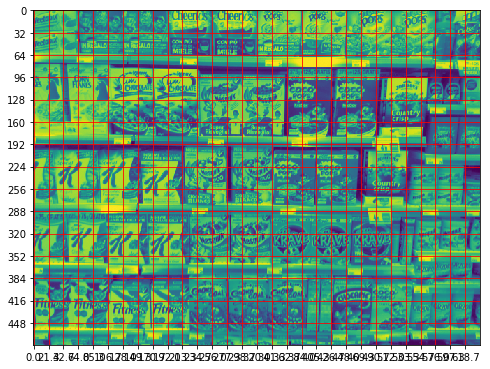

In [60]:
plot_grid_over_image(train,x_min,x_max,x_bin_size,y_min,y_max,y_bin_size)

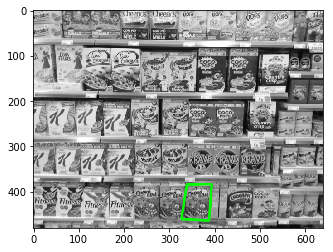

In [61]:
# Checking if we found enough matching
MIN_MATCH_COUNT = 10
if len(good_matches.keys())>MIN_MATCH_COUNT:
    # building the corrspondences arrays of good matches
    src_pts = np.float32([ kp_query[q].pt for _,q in good_matches.items() ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_train[t].pt for t,_ in good_matches.items() ]).reshape(-1,1,2)
    # Using RANSAC to estimate a robust homography. 
    # It returns the homography M and a mask for the discarded points
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # Mask of discarded point used in visualization
    matchesMask = mask.ravel().tolist()
   
    
    # Corners of the query image
    h,w = query.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    
    # Projecting the corners into the train image
    dst = cv2.perspectiveTransform(pts,M)

    train_rgb = cv2.cvtColor(train,cv2.COLOR_GRAY2RGB)
    
    # Drawing the bounding box
    train_rgb = cv2.polylines(train_rgb,[np.int32(dst)],True,(0,255,0),3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good_match.keys()), MIN_MATCH_COUNT) )
    matchesMask = None



plt.imshow(train_rgb),plt.show();

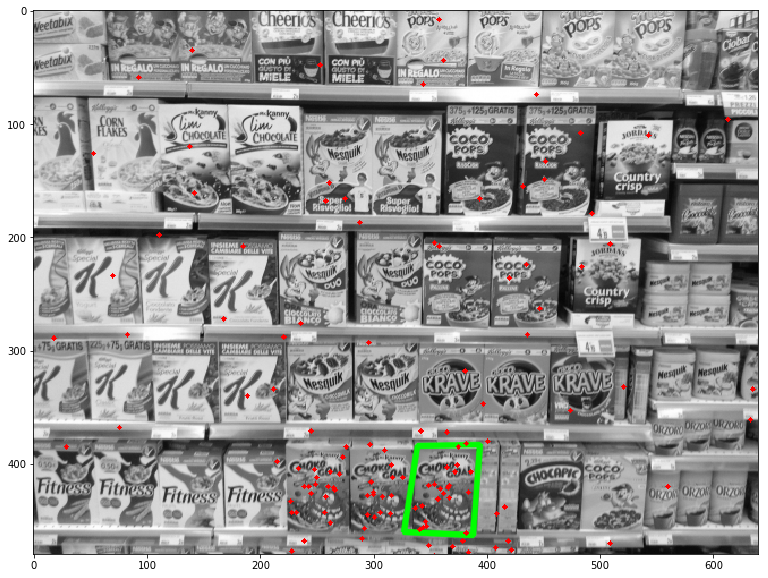

In [62]:
for v in hough_space.values():
    cv2.circle(train_rgb, (int(v['x_c']),int(v['y_c'])), radius=2, color=(255, 0, 0), thickness=-1)
plt.figure(figsize = (15,10))
plt.imshow(train_rgb),plt.show();

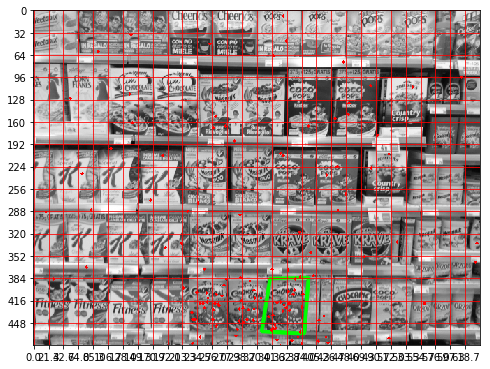

In [63]:
plot_grid_over_image(train_rgb,x_min,x_max,x_bin_size,y_min,y_max,y_bin_size)